# Super resolución de imágenes usando redes convolucionales
**Autores**

* Oleg Sovero
* Jose Huertas
* Gustavo Rojas
* Alfredo Tarazona

In [ ]:
# Fuentes de información:
# https://keras.io/examples/vision/super_resolution_sub_pixel/
# https://blog.paperspace.com/image-super-resolution/

In [ ]:
# Importamos las librerias
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display


In [ ]:
# Montar en el directorio de drive, asi no gastamos mucha ram
from google.colab import drive
drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Dataset"
%cd $working_dir

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1HWgELbfAzgbCmGvQOJLuIEqQ7rDlmM_v/Dataset


In [ ]:
%ls $working_dir

/content/drive/MyDrive/Dataset@


In [ ]:
train_path = working_dir + '/Training_Set'
valid_path = working_dir + '/Validation_Set'

In [ ]:
target_size = 300 # Reduciremos el tamaño de imagen a la mitad para poder ampliarla más adelante
upscale_factor = 3 # factor de ampliación
input_size = target_size // upscale_factor

# Crea los conjuntos de datos de entrenamiento y validación y establece los tamaños de imagen en 256x256 de forma predeterminada
train_data_raw = tf.keras.preprocessing.image_dataset_from_directory(train_path, label_mode=None, image_size=(target_size, target_size))
validate_data_raw = tf.keras.preprocessing.image_dataset_from_directory(valid_path, label_mode=None, image_size=(target_size, target_size))

Found 140 files belonging to 1 classes.
Found 40 files belonging to 1 classes.


In [ ]:
# Escalamos las imágenes para que el valor de cada píxel este en el rango de 0 y 1

def scale(img):
    return (img)/255.0

train_data = train_data_raw.map(scale)
validate_data = validate_data_raw.map(scale)

In [ ]:
test_path  = working_dir + '/Test_Set' + '/LR'# directorio de conjunto de testeo.

In [ ]:
#dataset_path = os.path.join(root_path, "images")
#test_path = os.path.join(dataset_path, "test")

# Creamos una lista con las rutas de todas las imágenes en el subconjunto de prueba y luego la ordenamos

test_imgs = []

for img in os.listdir(test_path):
  if img.endswith(".png"):
    test_imgs.append(os.path.join(test_path, img))

test_imgs = sorted(test_imgs)

In [ ]:
def process_input(img, target_size, upscale_factor):
    return tf.image.resize(img, [target_size, target_size], method="area")


def process_target(img):
    img = tf.image.rgb_to_yuv(img) # Cambiamos el formato de la imagen a una escala yuv
    return tf.split(img, 3, axis=3)[0]


train_data_yuv = train_data.map(process_target)
train_data_scaled = train_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

train_ds = train_data_scaled.prefetch(buffer_size=32) #

validate_data_yuv = validate_data.map(process_target)
validate_data_scaled = validate_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

valid_ds = validate_data_scaled.prefetch(buffer_size=32) #


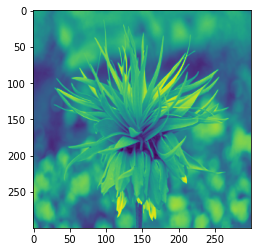

<Figure size 21600x21600 with 0 Axes>

(300, 300) 



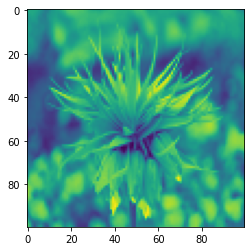

<Figure size 7200x7200 with 0 Axes>

(100, 100)


In [ ]:
l = list(train_ds)

# Mostramos una imagen con baja y con alta resolución de nuestro conjunto de datos
img1 = tf.keras.preprocessing.image.array_to_img(l[0][1][0])
plt.imshow(img1)
plt.figure(figsize=(img1.size[0], img1.size[1]))
plt.show()
print(img1.size,"\n")

img2 = tf.keras.preprocessing.image.array_to_img(l[0][0][0])
plt.imshow(img2)
plt.figure(figsize=(img2.size[0], img2.size[1]))
plt.show()
print(img2.size)

In [ ]:
import cv2
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0
    
    # Creamos una nueva figura con una subimagen 111 predeterminada. Esto para los resultados
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")
    
    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")
    
    # Especificamos los limites.
    x1, x2, y1, y2 = 50, 75, 25, 50   # 200, 300, 100, 200
    # Aplicamos los limites de x.
    axins.set_xlim(x1, x2)
    # Aplicamos los limites de y.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)
    
    # Marcamos la linea.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    if not os.path.exists('images_out'):
      os.makedirs('images_out')
    plt.savefig("images_out/" + str(prefix) + "-" + title + ".png")
    plt.show()

def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize((img.size[0] // upscale_factor, img.size[1] // upscale_factor),PIL.Image.BICUBIC)

def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restauramos la imagen en el espacio de color RGB.
    
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

In [ ]:
# Usamos ESPCN como un callback para imprimir las métricas en cada época.
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_imgs[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
loss_function = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs = 100

# Definición de la red con capas convolucionales

# Aquí estará la serie de argumentos por cada capa
conv_args = {"kernel_initializer": "Orthogonal",
             "padding": "same"}

inputs = keras.Input(shape=(None, None, 1))

x = layers.Conv2D(64, 3, **conv_args)(inputs)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 3, **conv_args)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 3, **conv_args)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1 * (upscale_factor ** 2), 3, **conv_args)(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

callbacks = [ESPCNCallback(), early_stopping_callback]

# compilamos el modelo
model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=loss_function)

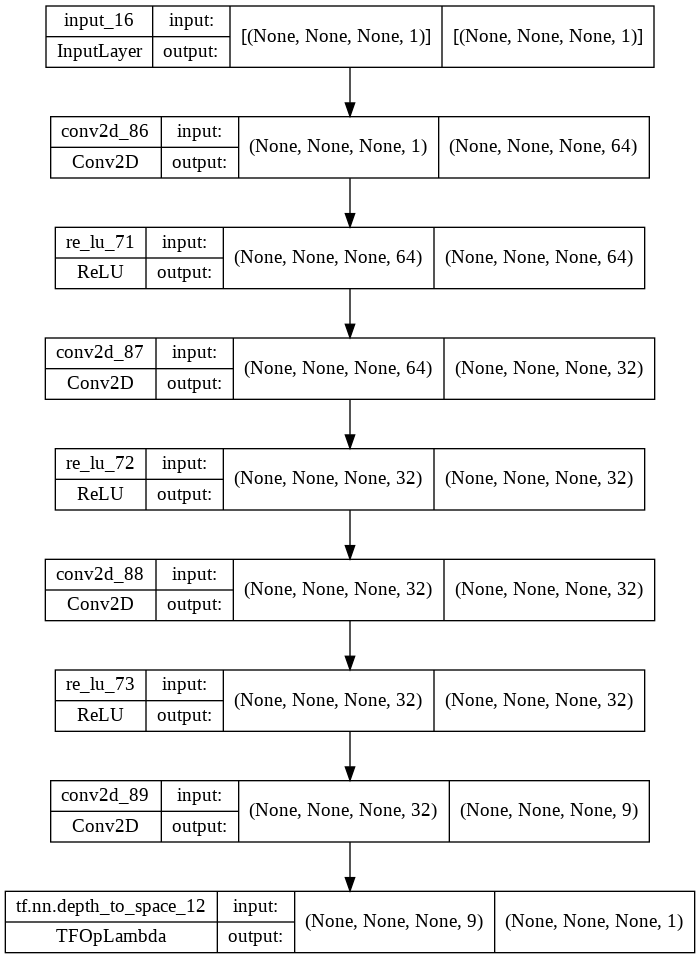

In [ ]:
# Graficamos el modelo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100
Mean PSNR for epoch: 11.15


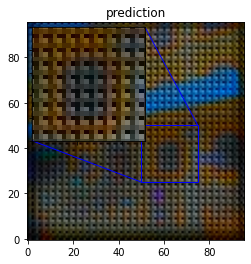

5/5 - 2s - loss: 0.2165 - val_loss: 0.0761 - 2s/epoch - 444ms/step
Epoch 2/100
Mean PSNR for epoch: 14.68
5/5 - 1s - loss: 0.0520 - val_loss: 0.0338 - 1s/epoch - 234ms/step
Epoch 3/100
Mean PSNR for epoch: 16.70
5/5 - 1s - loss: 0.0225 - val_loss: 0.0215 - 1s/epoch - 228ms/step
Epoch 4/100
Mean PSNR for epoch: 17.50
5/5 - 1s - loss: 0.0241 - val_loss: 0.0171 - 1s/epoch - 221ms/step
Epoch 5/100
Mean PSNR for epoch: 18.18
5/5 - 1s - loss: 0.0166 - val_loss: 0.0149 - 1s/epoch - 220ms/step
Epoch 6/100
Mean PSNR for epoch: 19.21
5/5 - 1s - loss: 0.0128 - val_loss: 0.0117 - 1s/epoch - 223ms/step
Epoch 7/100
Mean PSNR for epoch: 19.80
5/5 - 1s - loss: 0.0122 - val_loss: 0.0105 - 1s/epoch - 235ms/step
Epoch 8/100
Mean PSNR for epoch: 20.28
5/5 - 1s - loss: 0.0103 - val_loss: 0.0090 - 1s/epoch - 228ms/step
Epoch 9/100
Mean PSNR for epoch: 21.23
5/5 - 1s - loss: 0.0086 - val_loss: 0.0076 - 1s/epoch - 220ms/step
Epoch 10/100
Mean PSNR for epoch: 21.73
5/5 - 1s - loss: 0.0074 - val_loss: 0.0066 - 

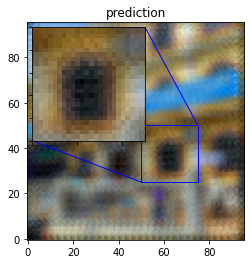

5/5 - 2s - loss: 0.0035 - val_loss: 0.0034 - 2s/epoch - 338ms/step
Epoch 22/100
Mean PSNR for epoch: 25.15
5/5 - 1s - loss: 0.0033 - val_loss: 0.0032 - 1s/epoch - 226ms/step
Epoch 23/100
Mean PSNR for epoch: 25.20
5/5 - 1s - loss: 0.0031 - val_loss: 0.0030 - 1s/epoch - 235ms/step
Epoch 24/100
Mean PSNR for epoch: 25.33
5/5 - 1s - loss: 0.0029 - val_loss: 0.0028 - 1s/epoch - 240ms/step
Epoch 25/100
Mean PSNR for epoch: 25.89
5/5 - 1s - loss: 0.0028 - val_loss: 0.0026 - 1s/epoch - 224ms/step
Epoch 26/100
Mean PSNR for epoch: 25.75
5/5 - 1s - loss: 0.0026 - val_loss: 0.0025 - 1s/epoch - 233ms/step
Epoch 27/100
Mean PSNR for epoch: 26.22
5/5 - 1s - loss: 0.0025 - val_loss: 0.0024 - 1s/epoch - 227ms/step
Epoch 28/100
Mean PSNR for epoch: 26.31
5/5 - 1s - loss: 0.0024 - val_loss: 0.0023 - 1s/epoch - 229ms/step
Epoch 29/100
Mean PSNR for epoch: 26.65
5/5 - 1s - loss: 0.0023 - val_loss: 0.0023 - 1s/epoch - 234ms/step
Epoch 30/100
Mean PSNR for epoch: 26.32
5/5 - 1s - loss: 0.0023 - val_loss: 0

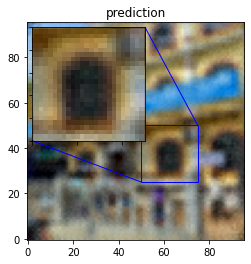

5/5 - 2s - loss: 0.0019 - val_loss: 0.0019 - 2s/epoch - 330ms/step
Epoch 42/100
Mean PSNR for epoch: 27.10
5/5 - 1s - loss: 0.0019 - val_loss: 0.0019 - 1s/epoch - 227ms/step
Epoch 43/100
Mean PSNR for epoch: 27.54
5/5 - 1s - loss: 0.0019 - val_loss: 0.0019 - 1s/epoch - 228ms/step
Epoch 44/100
Mean PSNR for epoch: 27.34
5/5 - 1s - loss: 0.0019 - val_loss: 0.0019 - 1s/epoch - 234ms/step
Epoch 45/100
Mean PSNR for epoch: 27.45
5/5 - 1s - loss: 0.0019 - val_loss: 0.0018 - 1s/epoch - 227ms/step
Epoch 46/100
Mean PSNR for epoch: 27.22
5/5 - 1s - loss: 0.0019 - val_loss: 0.0018 - 1s/epoch - 242ms/step
Epoch 47/100
Mean PSNR for epoch: 26.37
5/5 - 1s - loss: 0.0019 - val_loss: 0.0024 - 1s/epoch - 221ms/step
Epoch 48/100
Mean PSNR for epoch: 27.38
5/5 - 1s - loss: 0.0021 - val_loss: 0.0019 - 1s/epoch - 229ms/step
Epoch 49/100
Mean PSNR for epoch: 27.57
5/5 - 1s - loss: 0.0020 - val_loss: 0.0018 - 1s/epoch - 232ms/step
Epoch 50/100
Mean PSNR for epoch: 27.35
5/5 - 1s - loss: 0.0019 - val_loss: 0

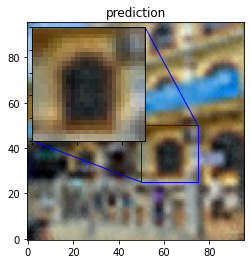

5/5 - 2s - loss: 0.0017 - val_loss: 0.0017 - 2s/epoch - 385ms/step
Epoch 62/100
Mean PSNR for epoch: 27.91
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 231ms/step
Epoch 63/100
Mean PSNR for epoch: 27.91
5/5 - 1s - loss: 0.0018 - val_loss: 0.0017 - 1s/epoch - 236ms/step
Epoch 64/100
Mean PSNR for epoch: 27.88
5/5 - 1s - loss: 0.0018 - val_loss: 0.0017 - 1s/epoch - 226ms/step
Epoch 65/100
Mean PSNR for epoch: 27.65
5/5 - 1s - loss: 0.0018 - val_loss: 0.0017 - 1s/epoch - 228ms/step
Epoch 66/100
Mean PSNR for epoch: 27.74
5/5 - 1s - loss: 0.0018 - val_loss: 0.0017 - 1s/epoch - 223ms/step
Epoch 67/100
Mean PSNR for epoch: 27.57
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 228ms/step
Epoch 68/100
Mean PSNR for epoch: 27.73
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 224ms/step
Epoch 69/100
Mean PSNR for epoch: 27.71
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 224ms/step
Epoch 70/100
Mean PSNR for epoch: 27.84
5/5 - 1s - loss: 0.0017 - val_loss: 0

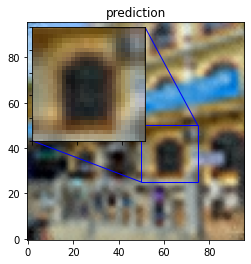

5/5 - 2s - loss: 0.0017 - val_loss: 0.0016 - 2s/epoch - 379ms/step
Epoch 82/100
Mean PSNR for epoch: 28.29
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 234ms/step
Epoch 83/100
Mean PSNR for epoch: 28.30
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 231ms/step
Epoch 84/100
Mean PSNR for epoch: 27.92
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 221ms/step
Epoch 85/100
Mean PSNR for epoch: 27.69
5/5 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 226ms/step
Epoch 86/100
Mean PSNR for epoch: 28.07
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 230ms/step
Epoch 87/100
Mean PSNR for epoch: 27.91
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 223ms/step
Epoch 88/100
Mean PSNR for epoch: 28.37
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 224ms/step
Epoch 89/100
Mean PSNR for epoch: 27.70
5/5 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 228ms/step
Epoch 90/100
Mean PSNR for epoch: 28.18
5/5 - 1s - loss: 0.0017 - val_loss: 0

In [ ]:
# Entrenamos el modelo
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2, callbacks=callbacks)

PSNR of low resolution image and high resolution image is 19.6917
PSNR of predict and high resolution is 19.8757


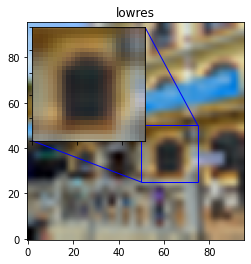

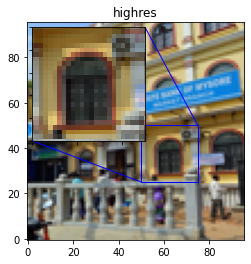

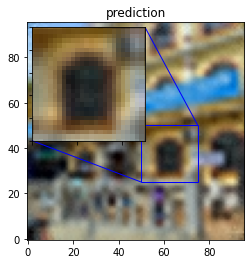

PSNR of low resolution image and high resolution image is 21.2354
PSNR of predict and high resolution is 21.3487


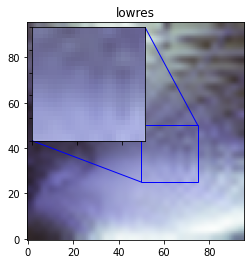

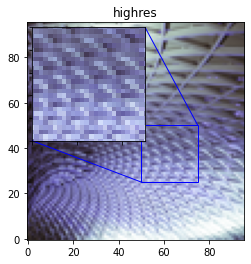

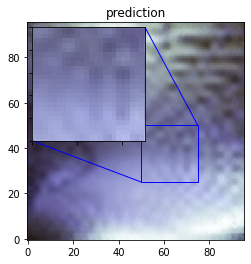

PSNR of low resolution image and high resolution image is 21.6377
PSNR of predict and high resolution is 21.8218


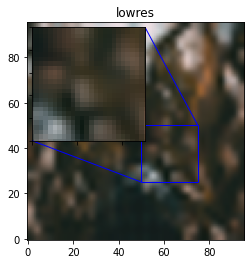

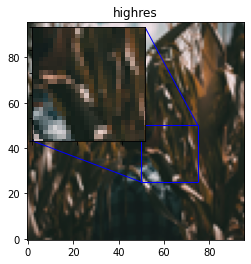

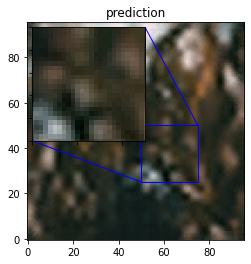

PSNR of low resolution image and high resolution image is 23.6507
PSNR of predict and high resolution is 23.8840


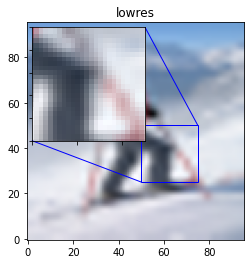

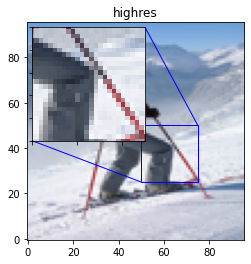

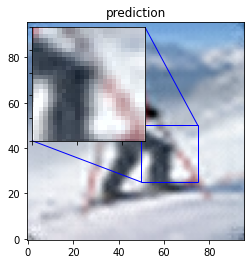

PSNR of low resolution image and high resolution image is 22.8828
PSNR of predict and high resolution is 23.0327


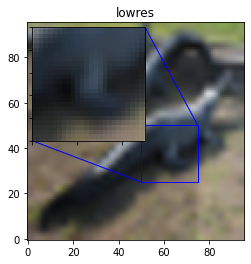

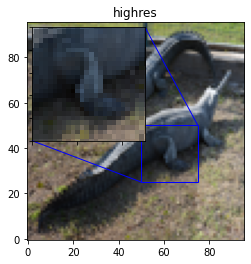

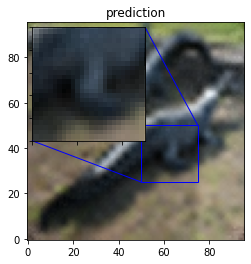

PSNR of low resolution image and high resolution image is 21.7413
PSNR of predict and high resolution is 22.2811


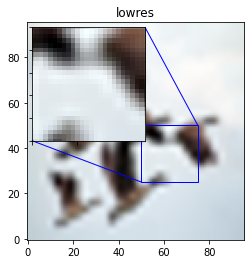

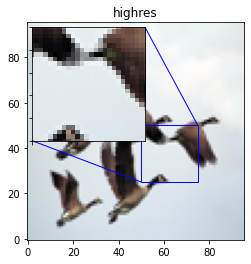

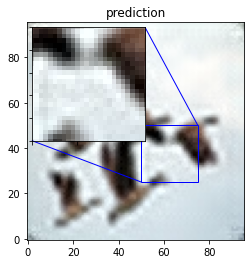

PSNR of low resolution image and high resolution image is 19.2135
PSNR of predict and high resolution is 19.4078


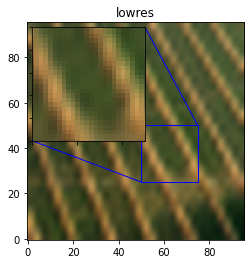

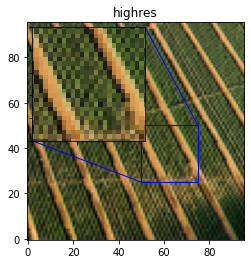

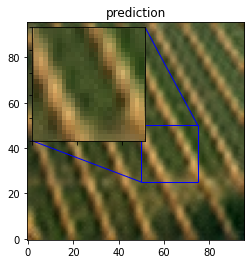

PSNR of low resolution image and high resolution image is 23.8103
PSNR of predict and high resolution is 24.0420


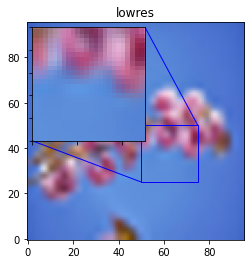

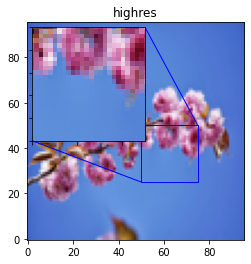

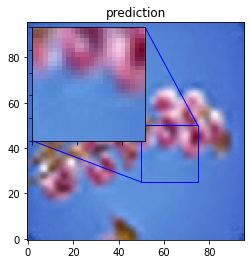

PSNR of low resolution image and high resolution image is 19.0147
PSNR of predict and high resolution is 19.1509


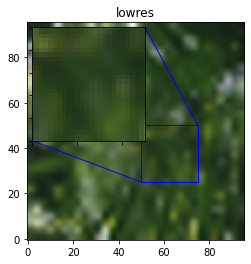

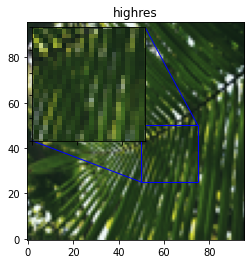

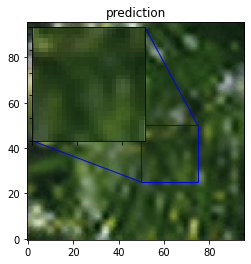

PSNR of low resolution image and high resolution image is 20.7380
PSNR of predict and high resolution is 20.9612


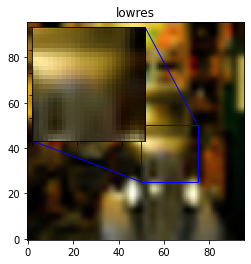

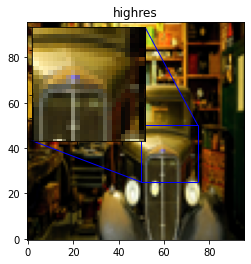

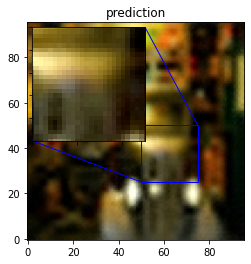

Avg. PSNR of lowres images is 85.4464
Avg. PSNR of reconstructions is 60.4004


In [ ]:
# Resultados del modelo entrenado
for index, test_img_path in enumerate(test_imgs[0:10]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))